In [28]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7039431942823946181
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6253707264
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10616188338569660254
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Исследование ***KNN*** на датасете **MNIST**


## Первый взгляд

### Подгрузка данных
Подгрузим датасет ***MNIST*** через sklearn.datasets и посмотрим, что он из себя представляет

In [30]:
# from google.colab import drive
# drive.mount('/content/drive')
!pip install scikit-learn
!pip install pandas
!pip install pillow
!pip install matplotlib

In [31]:
import sklearn.datasets
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [258]:
%matplotlib inline

In [32]:
mnist = sklearn.datasets.fetch_openml("mnist_784")

In [33]:
mnist_df = pd.DataFrame(np.c_[mnist.data.astype('float32'), mnist.target.astype('int64')], columns=np.append(mnist.feature_names, ["target"]))
mnist_df['target'] = mnist_df['target'].astype('int64')

In [34]:
from IPython.display import display, HTML

# Visualizing MNIST dataset
print("Dataframe 1:")
display(HTML(mnist_df.head(10).to_html()))

Dataframe 1:


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel456,pix

### Препроцессинг
Датасет ***MNIST*** хранит каждый объект в виде 784-размерного вектора пикселей, который кодирует картинку 28 x 28. Каждый пиксель имеет значение $p \in [0, 255]$, отражающее оттенок пикселя по шкале серого цвета. Для избежания больших весов при обучении модели нормализуем значения пикселей и переведём их в отрезок от 0 до 1. $[0, 255] \sim [0, 1]$

In [123]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X_np = X.to_numpy()
y_np = y.to_numpy()

In [36]:
X /= 255

In [37]:
X_train = X.head(60000).to_numpy()
y_train = y.head(60000).to_numpy()
X_test = X.tail(10000).to_numpy()
y_test = y.tail(10000).to_numpy()

### Визуализация

In [474]:
def vizualize_mnist(X, count=None):
    plt.figure(figsize=(12, 12))
    if count is None:
        count = X.shape[0]
    for i, img in enumerate(X[:count].reshape(count, 28, 28)):
        plt.subplot(1, count, 1 + i)
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
        plt.title(f"№{i}")

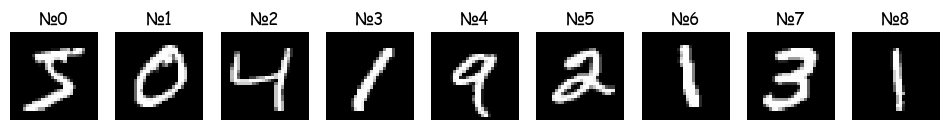

In [475]:
vizualize_mnist(X_train, 9)

## Весь необходимый код из трёх модулей

### Модуль ***distances.py***

In [91]:
def euclidean_distance(x, y):
    """
    Returns matrix where the [i, j]-th element is the euclidean distance
    between the i-th object of x and the j-th object of y. x and y shouldn't contain zero
    :param x: np.ndarray with the shape of N x D
    :param y: np.ndarray with the shape of M x D
    :return: np.ndarray with the shape of N x M
    """
    x_squares = (x * x).sum(axis=1).reshape(-1, 1)
    y_squares = (y * y).sum(axis=1).reshape(-1, 1)
    scalar_product = x @ y.T

    x_squares_add1 = np.concatenate((x_squares, np.ones_like(x_squares)), 1)
    y_squares_add1 = np.concatenate((np.ones_like(y_squares), y_squares), 1)
    squares_sum = x_squares_add1 @ y_squares_add1.T

    distance = squares_sum - scalar_product * 2.0
    distance = distance * (distance > 0)
    return np.sqrt(distance)


def cosine_distance(x, y):
    """
    Returns matrix where the [i, j]-th element is the cosine distance
    between the i-th object of x and the j-th object of y. x and y shouldn't contain zero
    :param x: np.ndarray with the shape of N x D
    :param y: np.ndarray with the shape of M x D
    :return: np.ndarray with the shape of N x M
    """
    x_norms = np.sqrt((x * x).sum(axis=1).reshape(-1, 1))
    y_norms = np.sqrt((y * y).sum(axis=1).reshape(-1, 1))
    scalar_product = x @ y.T

    x_norms_add0 = np.concatenate((x_norms, np.zeros_like(x_norms)), 1)
    y_norms_add0 = np.concatenate((y_norms, np.zeros_like(y_norms)), 1)
    norms_product = x_norms_add0 @ y_norms_add0.T

    distance = 1.0 - scalar_product / norms_product
    distance = distance * (np.abs(distance) > 1e-8)
    return distance


### Модуль ***nearest_neighbors.py***

In [41]:
from sklearn.neighbors import NearestNeighbors


class KNNClassifier:
    def __init__(self, k, strategy, metric, weights, test_block_size):
        """
        Initialization for KNNClassifier
        :param k: int. The count of the nearest neighbors - hyperparameter
        :param strategy: str. 'my_own', 'brute', 'kd_tree', 'ball_tree'
        :param metric: str. 'euclidean', 'cosine'
        :param weights: bool. True for the weighted KNN method and False otherwise
        :param test_block_size: The size of test data blocks
        """
        self.__is_valid(k, strategy, metric, weights, test_block_size)  # checking arguments
        self.k = k
        self._eps = 1e-5
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size
        self._implemented_data = None
        self._fitted_data = None
        self._targets_values = None

    @staticmethod
    def __is_valid(k, strategy, metric, weights, test_block_size):
        """
        Checking if the arguments are acceptable
        :param k: int. The count of the nearest neighbors - hyperparameter
        :param strategy: str. 'my_own', 'brute', 'kd_tree', 'ball_tree'
        :param metric: str. 'euclidean', 'cosine'
        :param weights: bool. True for the weighted KNN method and False otherwise
        :param test_block_size: The size of test data blocks
        :return: Nothing to return
        """
        strats = ['my_own', 'brute', 'kd_tree', 'ball_tree']
        metrics = ['euclidean', 'cosine']

        assert isinstance(k, int), 'k should be an int'
        assert strategy in strats, 'Use only acceptable strategies'
        assert metric in metrics, 'Use only acceptable metrics'
        assert isinstance(weights, bool), 'weights should be a bool'
        assert isinstance(test_block_size, int), 'test_block_size should be an int'

        if strategy in ['kd_tree', 'ball_tree'] and metric != 'euclidean':
            raise AssertionError('Use euclidean metrics with kd_tree and ball_tree')

    def _kneighbors(self, x, return_distance=True):
        """
        Finds k nearest neighbors for each object in the dataset but with a choice of algorithm.
        :param x: np.ndarray. Dataset
        :return: Tuple. The first element is a matrix[x.shape[0], k] of distances where [i, j] element is the
        distance between the i-th object of x and its j-th neighbor. The second element is a
        matrix[X.shape[0], k] of indices where [i, j] element is the index of the j-th nearest neighbor from
        the dataset for the i-th object. If return_distance is False then the function returns an empty np.ndarray as
        the first element of the tuple.
        """
        dist = np.array([])

        if self._implemented_data is not None:
            if return_distance:
                dist, ind = self._implemented_data.kneighbors(x, self.k)
            else:
                ind = self._implemented_data.kneighbors(x, self.k, False)
        else:
            if self.metric == 'euclidean':
                dist_matrix = euclidean_distance(x, self._fitted_data)
            else:
                dist_matrix = cosine_distance(x, self._fitted_data)

            index_array = np.argpartition(dist_matrix, kth=self.k - 1, axis=-1)[:, :self.k]
            rows = np.arange(index_array.shape[0])[:, None]
            dist_array = dist_matrix[rows, index_array]
            sorted_index = np.argsort(dist_array, axis=-1)
            dist = dist_array[rows, sorted_index]
            ind = index_array[rows, sorted_index]

        return dist, ind

    def fit(self, x, y):
        """
        Fitting our model to the train dataset
        Saves data under the method requirements
        :param x: np.ndarray. Train dataset
        :param y: np.ndarray. Target values
        :return: self
        """
        self._targets_values = y

        if self.strategy != 'my_own':
            self._implemented_data = NearestNeighbors(n_neighbors=self.k, algorithm=self.strategy)
            self._implemented_data.fit(x)
        else:
            self._fitted_data = x
        return self

    def find_kneighbors(self, x, return_distance):
        """
        Finds k nearest neighbors for each object in the dataset
        :param x: np.ndarray. Dataset
        :param return_distance: bool. Returns the first ndarray only if True
        :return: Tuple. The first element is a matrix[x.shape[0], k] of distances where [i, j] element is the
        distance between the i-th object of x and its j-th neighbor. The second element is a
        matrix[X.shape[0], k] of indices where [i, j] element is the
        index of the j-th nearest neighbor from the dataset for the i-th object.
        """
        distances = np.array([])
        indices = np.array([])

        for i in range(0, x.shape[0], self.test_block_size):
            end_index = i + self.test_block_size
            if end_index >= x.shape[0]:
                end_index = x.shape[0]

            dist, ind = self._kneighbors(x[i:end_index], return_distance)
            distances = np.concatenate([distances, dist]) if distances.size else dist
            indices = np.concatenate([indices, ind]) if indices.size else ind

        if return_distance:
            return distances, indices
        else:
            return indices

    def predict(self, x, dist=None, ind=None):
        """
        Returns the predicted classes' labels
        :param x: np.ndarray. Test dataset
        :param dist: np.ndarray. A matrix of distances
        :param ind: np.ndarray. A matrix of indices
        :return: np.ndarray. It's a matrix[X.shape[0]] of the classes' labels
        """
        if self.weights:
            distances, indices = self.find_kneighbors(x, True) \
                if dist is None or ind is None else (dist, ind)
            weight_matrix = 1.0 / (distances + self._eps)
        else:
            indices = self.find_kneighbors(x, False) if ind is None else ind
            weight_matrix = np.ones_like(indices)

        values = self._targets_values[indices]

        unique = np.unique(values)
        weights_dict = {un: np.sum(weight_matrix * (values == un), axis=1) for un in unique}
        max_array = np.array([weights_dict[un] for un in unique])
        target = unique[np.argmax(max_array, axis=0)]

        return target


### Модуль ***cross_validation.py***

In [122]:
def get_accuracy(predict, target):
    """
    Estimates the fraction of predictions the model got right.
    :param predict: np.ndarray. Our predictions
    :param target: np,ndarray. Our true values
    :return: float. The result accuracy
    """
    return np.count_nonzero(predict == target) / target.shape[0]


def cross_predict_score(values, weights, target, function, k_list, k_dict, n):
    """
    Estimates the score of the prediction specified in function
    :param values: the matrix of labels
    :param weights: the matrix of weights
    :param target: real values
    :param function: estimator
    :param k_list: cross-validation k_list
    :param k_dict: the dict for result estimations
    :param n: current fold
    :return: prediction score
    """
    if not len(k_list):
        return

    prev_k = 0
    unique = np.unique(values)
    weights_dict = {un: 0 for un in unique}
    for k in k_list:
        weights_dict = {un: weights_dict[un] + np.sum(weights[:, prev_k:k] * (values[:, prev_k:k] == un), axis=1)
                        for un in unique}
        max_array = np.array([weights_dict[un] for un in unique])
        predict = unique[np.argmax(max_array, axis=0)]
        k_dict[k][n] = function(predict, target)
        prev_k = k


def kfold(n, n_folds):
    """
    Creates indices for train and test datasets
    :param n: A dataset size
    :param n_folds: The count of the folds
    :return: list of tuples with train and test indices
    """

    indices = np.arange(n)
    result = list()

    if n % n_folds:
        first_ind = np.arange((n % n_folds) * (n // n_folds + 1))
        first_tests = first_ind.reshape(n % n_folds, -1)
        result = [(np.delete(indices, test), test) for test in first_tests]
        second_ind = np.arange((n % n_folds) * (n // n_folds + 1), n)
    else:
        second_ind = indices

    second_tests = second_ind.reshape(n_folds - n % n_folds, -1)
    for test in second_tests:
        result.append((np.delete(indices, test), test))
    return result


def knn_cross_val_score(x, y, k_list, score, cv, **kwargs):
    """
    Counts cross validation score for each k in k_list
    :param x: dataset objects
    :param y: target values
    :param k_list: hyperparameters for knn
    :param score: the name of the estimation metric
    :param cv: list of tuples containing indices for train and test splitting
    :param kwargs: arguments for KNNClassifier
    :return: dict of scores for each k
    """
    folds_count = 3
    eps = 1e-5
    score_functions = [get_accuracy]
    score_name = {'accuracy': 0}
    score_fun = score_functions[score_name[score]]

    knn = KNNClassifier(k_list[-1], **kwargs)
    if cv is None:
        cv = kfold(x.shape[0], folds_count)

    k_dict = dict()
    for k in k_list:
        k_dict[k] = np.zeros(len(cv))

    for n, (train, test) in enumerate(cv):
        knn.fit(x[train], y[train])
        if knn.weights:
            dist, ind = knn.find_kneighbors(x[test], knn.weights)
            weight_matrix = 1.0 / (dist + eps)
        else:
            dist, ind = None, knn.find_kneighbors(x[test], knn.weights)
            weight_matrix = np.ones_like(ind)
        values = y[train][ind]
        cross_predict_score(values, weight_matrix, y[test], score_fun, k_list, k_dict, n)

    return k_dict


## **Эксперимент первый** - *оценка различных стратегий поиска ближайших соседей*


### Создаём случайную выборку признаков и инициализируем базовые переменные

In [43]:
# Сэмплы из 10, 20 и 100 случайных признаков (их индексы)
rng = np.random.default_rng()

indices_10 = rng.choice(X_train.shape[1], size=10, replace=False)
indices_20 = rng.choice(X_train.shape[1], size=20, replace=False)
indices_100 = rng.choice(X_train.shape[1], size=100, replace=False)

In [44]:
neighbors_count = 5
test_block_size = 10

### Проверяем метод **my_own**

In [92]:
my_own_knn = KNNClassifier(neighbors_count, 'my_own', 'euclidean', False, test_block_size)

#### Выборка из 10 признаков

In [106]:
my_own_knn.fit(X_train[:10, indices_10], y_train)

In [108]:
%%timeit
my_own_knn.find_kneighbors(X_train[:10, indices_10], True)

45.8 µs ± 252 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Выборка из 20 признаков

In [109]:
my_own_knn.fit(X_train[:, indices_20], y_train)

In [110]:
%%timeit
my_own_knn.find_kneighbors(X_train[:, indices_20], True)

57.2 s ± 656 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Выборка из 100 признаков

In [98]:
my_own_knn.fit(X_train[:, indices_100], y_train)

In [99]:
%%time
my_own_knn.find_kneighbors(X_train[:, indices_100], True)

Wall time: 1min 40s


(array([[-0.       ,  1.4818228,  1.628159 ,  1.6549631,  1.7484217],
        [ 0.       ,  0.824752 ,  0.9911489,  1.0301564,  1.0578927],
        [ 0.       ,  1.6453496,  1.6875465,  1.6977494,  1.8065797],
        ...,
        [ 0.       ,  1.3427411,  1.4997883,  1.5956924,  1.6215343],
        [-0.       ,  1.1145535,  1.3753703,  1.5039101,  1.5205878],
        [-0.       ,  1.1879834,  1.2122977,  1.2273763,  1.2517425]],
       dtype=float32),
 array([[    0, 20223, 38193,  5067, 39595],
        [    1, 31059,  2581, 13280, 47714],
        [    2,  5362, 28657, 31743, 26652],
        ...,
        [59997, 45692, 40736, 45883, 17971],
        [59998, 29647, 29971, 29221, 23697],
        [59999, 55850,  1585,  1421, 41813]], dtype=int64))

### Проверяем метод **brute**

In [52]:
brute_knn = KNNClassifier(neighbors_count, 'brute', 'euclidean', False, test_block_size)

#### Выборка из 10 признаков

In [53]:
brute_knn.fit(X_train[:, indices_10], y_train)

In [54]:
%%time
brute_knn.find_kneighbors(X_train[:, indices_10], True)

Wall time: 48.4 s


(array([[0.        , 0.00554594, 0.01999615, 0.02218374, 0.02385397],
        [0.        , 0.11560315, 0.12055236, 0.12288971, 0.12887588],
        [0.        , 0.15632258, 0.19541062, 0.24304235, 0.24864106],
        ...,
        [0.        , 0.        , 0.00784314, 0.02111829, 0.02352941],
        [0.        , 0.06024428, 0.06298971, 0.07714633, 0.07823505],
        [0.        , 0.02480218, 0.02630668, 0.02659737, 0.02854945]],
       dtype=float32),
 array([[    0, 17185, 22951, 59941, 56358],
        [    1, 26219, 26937, 28967,  4079],
        [    2, 28717, 15072, 15134, 50248],
        ...,
        [59997, 15047, 56782, 59193, 23377],
        [59998, 13979, 32329, 24851, 55468],
        [59999,  9200, 42054, 30069, 46397]], dtype=int64))

#### Выборка из 20 признаков

In [55]:
brute_knn.fit(X_train[:, indices_20], y_train)

In [56]:
%%time
brute_knn.find_kneighbors(X_train[:, indices_20], True)

Wall time: 59.5 s


(array([[0.        , 0.        , 0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.10120383, 0.10248735, 0.11926986, 0.12958989],
        [0.        , 0.06024428, 0.07583955, 0.07882255, 0.12845756],
        ...,
        [0.        , 0.        , 0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.14220758, 0.17245987, 0.20695335, 0.20891327],
        [0.        , 0.06937964, 0.0781367 , 0.07998465, 0.09557693]],
       dtype=float32),
 array([[18855,     0,  1335, 46199, 16308],
        [    1, 45997, 59331, 40553, 54035],
        [    2, 15604, 51735,  7730, 51557],
        ...,
        [49690, 59997, 21091, 14060, 47070],
        [59998, 31143, 59924, 19331, 50101],
        [59999, 32415, 43710, 18005, 38631]], dtype=int64))

#### Выборка из 100 признаков

In [57]:
brute_knn.fit(X_train[:, indices_100], y_train)

In [58]:
%%time
brute_knn.find_kneighbors(X_train[:, indices_100], True)

Wall time: 2min 56s


(array([[0.0000000e+00, 1.4818237e+00, 1.6281595e+00, 1.6549624e+00,
         1.7484217e+00],
        [0.0000000e+00, 8.2475168e-01, 9.9114883e-01, 1.0301566e+00,
         1.0578935e+00],
        [4.2146848e-08, 1.6453493e+00, 1.6875463e+00, 1.6977494e+00,
         1.8065795e+00],
        ...,
        [0.0000000e+00, 1.3427408e+00, 1.4997885e+00, 1.5956930e+00,
         1.6215342e+00],
        [0.0000000e+00, 1.1145537e+00, 1.3753697e+00, 1.5039101e+00,
         1.5205879e+00],
        [0.0000000e+00, 1.1879829e+00, 1.2122977e+00, 1.2273759e+00,
         1.2517424e+00]], dtype=float32),
 array([[    0, 20223, 38193,  5067, 39595],
        [    1, 31059,  2581, 13280, 47714],
        [    2,  5362, 28657, 31743, 26652],
        ...,
        [59997, 45692, 40736, 45883, 17971],
        [59998, 29647, 29971, 29221, 23697],
        [59999, 55850,  1585,  1421, 41813]], dtype=int64))

### Проверяем метод **kd_tree**

In [59]:
kd_tree_knn = KNNClassifier(neighbors_count, 'kd_tree', 'euclidean', False, test_block_size)

#### Выборка из 10 признаков

In [60]:
kd_tree_knn.fit(X_train[:, indices_10], y_train)

In [61]:
%%time
kd_tree_knn.find_kneighbors(X_train[:, indices_10], True)

Wall time: 9.83 s


(array([[0.        , 0.00554594, 0.01999615, 0.02218374, 0.02385397],
        [0.        , 0.11560315, 0.12055236, 0.12288972, 0.12887589],
        [0.        , 0.15632259, 0.19541062, 0.24304235, 0.24864106],
        ...,
        [0.        , 0.        , 0.00784314, 0.02111829, 0.02352941],
        [0.        , 0.06024428, 0.06298972, 0.07714633, 0.07823504],
        [0.        , 0.02480218, 0.02630668, 0.02659737, 0.02854945]]),
 array([[    0, 17185, 22951, 59941, 56358],
        [    1, 26219, 26937, 28967,  4079],
        [    2, 28717, 15072, 15134, 50248],
        ...,
        [15047, 59997, 56782, 59193, 23377],
        [59998, 13979, 32329, 24851, 55468],
        [59999,  9200, 42054, 30069, 46397]], dtype=int64))

#### Выборка из 20 признаков

In [62]:
kd_tree_knn.fit(X_train[:, indices_20], y_train)

In [63]:
%%time
kd_tree_knn.find_kneighbors(X_train[:, indices_20], True)

Wall time: 25.4 s


(array([[0.        , 0.        , 0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.10120383, 0.10248735, 0.11926985, 0.12958989],
        [0.        , 0.06024428, 0.07583955, 0.07882255, 0.12845756],
        ...,
        [0.        , 0.        , 0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.14220758, 0.17245987, 0.20695334, 0.20891327],
        [0.        , 0.06937964, 0.0781367 , 0.07998465, 0.09557693]]),
 array([[    0, 18855, 46199, 16308,  1335],
        [    1, 45997, 59331, 40553, 54035],
        [    2, 15604, 51735,  7730, 51557],
        ...,
        [59997, 49690, 14060, 12910, 21091],
        [59998, 31143, 59924, 19331, 50101],
        [59999, 32415, 43710, 18005, 38631]], dtype=int64))

#### Выборка из 100 признаков

In [64]:
kd_tree_knn.fit(X_train[:, indices_100], y_train)

In [65]:
%%time
kd_tree_knn.find_kneighbors(X_train[:, indices_100], True)

Wall time: 8min 18s


(array([[0.        , 1.48182374, 1.62815954, 1.65496237, 1.74842161],
        [0.        , 0.82475167, 0.99114885, 1.03015659, 1.05789355],
        [0.        , 1.64534926, 1.68754628, 1.69774939, 1.80657947],
        ...,
        [0.        , 1.34274075, 1.49978852, 1.59569297, 1.62153425],
        [0.        , 1.11455369, 1.37536965, 1.50391009, 1.52058794],
        [0.        , 1.18798292, 1.21229765, 1.22737583, 1.25174236]]),
 array([[    0, 20223, 38193,  5067, 39595],
        [    1, 31059,  2581, 13280, 47714],
        [    2,  5362, 28657, 31743, 26652],
        ...,
        [59997, 45692, 40736, 45883, 17971],
        [59998, 29647, 29971, 29221, 23697],
        [59999, 55850,  1585,  1421, 41813]], dtype=int64))

### Проверяем метод **ball_tree**

In [66]:
ball_tree_knn = KNNClassifier(neighbors_count, 'ball_tree', 'euclidean', False, test_block_size)

#### Выборка из 10 признаков

In [67]:
ball_tree_knn.fit(X_train[:, indices_10], y_train)

In [68]:
%%time
ball_tree_knn.find_kneighbors(X_train[:, indices_10], True)

Wall time: 20.9 s


(array([[0.        , 0.00554594, 0.01999615, 0.02218374, 0.02385397],
        [0.        , 0.11560315, 0.12055236, 0.12288972, 0.12887589],
        [0.        , 0.15632259, 0.19541062, 0.24304235, 0.24864106],
        ...,
        [0.        , 0.        , 0.00784314, 0.02111829, 0.02352941],
        [0.        , 0.06024428, 0.06298972, 0.07714633, 0.07823504],
        [0.        , 0.02480218, 0.02630668, 0.02659737, 0.02854945]]),
 array([[    0, 17185, 22951, 59941, 56358],
        [    1, 26219, 26937, 28967,  4079],
        [    2, 28717, 15072, 15134, 50248],
        ...,
        [15047, 59997, 56782, 59193, 23377],
        [59998, 13979, 32329, 24851, 55468],
        [59999,  9200, 42054, 30069, 46397]], dtype=int64))

#### Выборка из 20 признаков

In [69]:
ball_tree_knn.fit(X_train[:, indices_20], y_train)

In [70]:
%%time
ball_tree_knn.find_kneighbors(X_train[:, indices_20], True)

Wall time: 1min 20s


(array([[0.        , 0.        , 0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.10120383, 0.10248735, 0.11926985, 0.12958989],
        [0.        , 0.06024428, 0.07583955, 0.07882255, 0.12845756],
        ...,
        [0.        , 0.        , 0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.14220758, 0.17245987, 0.20695334, 0.20891327],
        [0.        , 0.06937964, 0.0781367 , 0.07998465, 0.09557693]]),
 array([[18855,     0, 46199, 16308,  1335],
        [    1, 45997, 59331, 40553, 54035],
        [    2, 15604, 51735,  7730, 51557],
        ...,
        [59997, 49690, 21091, 12910, 14060],
        [59998, 31143, 59924, 19331, 50101],
        [59999, 32415, 43710, 18005, 38631]], dtype=int64))

#### Выборка из 100 признаков

In [71]:
ball_tree_knn.fit(X_train[:, indices_100], y_train)

In [72]:
%%time
ball_tree_knn.find_kneighbors(X_train[:, indices_100], True)

Wall time: 7min 54s


(array([[0.        , 1.48182374, 1.62815954, 1.65496237, 1.74842161],
        [0.        , 0.82475167, 0.99114885, 1.03015659, 1.05789355],
        [0.        , 1.64534926, 1.68754628, 1.69774939, 1.80657947],
        ...,
        [0.        , 1.34274075, 1.49978852, 1.59569297, 1.62153425],
        [0.        , 1.11455369, 1.37536965, 1.50391009, 1.52058794],
        [0.        , 1.18798292, 1.21229765, 1.22737583, 1.25174236]]),
 array([[    0, 20223, 38193,  5067, 39595],
        [    1, 31059,  2581, 13280, 47714],
        [    2,  5362, 28657, 31743, 26652],
        ...,
        [59997, 45692, 40736, 45883, 17971],
        [59998, 29647, 29971, 29221, 23697],
        [59999, 55850,  1585,  1421, 41813]], dtype=int64))

### Оценка результатов

Для подмножества из **10 случайно выбранных признаков** быстрее всего отработал алгоритм **my_own** с показателем времени, равным **45.8** $\mu s$. Это значительно отличается от методов *brute*, *kd_tree* и *ball_tree*, ибо на таком количестве признаков алгоритм отработал практически мгновенно. В методах *kd_tree* и *ball_tree* идут дополнительные построения структур данных, что занимает много времени, а имплементация метода brute хоть и имеет схожую идею, но, судя по результатам эксперимента, проигрывает по времени.

*Ранжирование по времени*: **my_own** ($45.8 \mu s$) $\longrightarrow$ **kd_tree** ($9.83 s$) $\longrightarrow$ **ball_tree** ($20.9 s$) $\longrightarrow$ **brute** ($48.4 s$)

Для подмножества из **20 случайно выбранных признаков** быстрее всего отработал алгоритм **kd_tree** с показателем времени, равным **25.4**$s$. На таком количестве признаков структура данных, реализованная методом *kd_tree* показывает себя гораздо лучше других алгоритмов.

*Ранжирование по времени*: **kd_tree** ($25.4 s$) $\longrightarrow$ **my_own** ($57.2 s$) $\longrightarrow$ **brute** ($59.5 s$) $\longrightarrow$ **ball_tree** ($1 min, 20s$)

Для подмножества из **100 случайно выбранных признаков** быстрее всего отработал алгоритм **my_own** с показателем времени, равным **1** $min$ **40**$s$. Интерпретация результата схожа с результатом для подмножества из 10 признаков, ибо построение структур данных требует времени.

*Ранжирование по времени*: **my_own** ($1 min, 40s$) $\longrightarrow$ **brute** ($2 min, 56 s$) $\longrightarrow$ **ball_tree** ($7 min, 54 s$) $\longrightarrow$ **kd_tree** ($8 min, 18s$)

## **Эксперимент второй** - *оценка точности на кросс-валидации*


Рассматриваем все алгоритмы поиска ближайших соседей и оцениваем точность и время работы алгоритмов для $k$ соседей, где $k \in [1, 10]$

Евклидова метрика используется для каждого метода поиска ближайших соседей, в то время как косинусная только с методами *my_own* и *brute*

Используем 3-х фолдовую нестратифицированную кросс-валидацию

### Евклидова метрика

#### Метод *my_own*

In [139]:
my_own_dict = {'strategy': 'my_own', 'metric': 'euclidean', 'weights': False, 'test_block_size': 100}

In [140]:
%%time
acc_euc_my_own = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **my_own_dict)

Wall time: 1min 40s


#### Метод *brute*

In [141]:
brute_dict = {'strategy': 'brute', 'metric': 'euclidean', 'weights': False, 'test_block_size': 100}

In [142]:
%%time
acc_euc_brute = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **brute_dict)

Wall time: 2min 36s


#### Метод *kd_tree*

In [143]:
kd_tree_dict = {'strategy': 'kd_tree', 'metric': 'euclidean', 'weights': False, 'test_block_size': 100}

In [144]:
%%time
acc_euc_kd_tree = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **kd_tree_dict)

Wall time: 50min 40s


#### Метод *ball_tree*

In [145]:
ball_tree_dict = {'strategy': 'ball_tree', 'metric': 'euclidean', 'weights': False, 'test_block_size': 100}

In [146]:
%%time
acc_euc_ball_tree = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **ball_tree_dict)

Wall time: 39min 58s


### Косинусная метрика

#### Метод *my_own*

In [147]:
my_own_dict = {'strategy': 'my_own', 'metric': 'cosine', 'weights': False, 'test_block_size': 100}

In [148]:
%%time
acc_cos_my_own = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **my_own_dict)

Wall time: 1min 37s


#### Метод *brute*

In [310]:
brute_dict = {'strategy': 'brute', 'metric': 'cosine', 'weights': False, 'test_block_size': 100}

In [311]:
%%time
acc_cos_brute = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **brute_dict)

Wall time: 2min 35s


### Оценка результатов эксперимента

Для каждой метрики быстрее всего отработал алгоритм **my_own** с показателями времени, равными **1**$min$**40**$s$ при евклидовой и **1**$min$**37**$s$ при косинусной.

Методы *kd_tree* и *ball_tree* показали достаточно большое время работы при кросс-валидации, так как на каждом новом фолде приходилось очередной раз проводить построение структур данных.

Вычисления оказались незначительно быстрее при косинусной метрике  

**Ранжирование по времени** 

*Евклидова метрика*: **my_own** ($1 min, 40 s$) $\longrightarrow$ **brute** ($2 min, 36 s$) $\longrightarrow$ **ball_tree** ($39 min, 58s$) $\longrightarrow$ **kd_tree** ($50 min, 40s$)

*Косинусная метрика*: **my_own** ($1 min, 37 s$) $\longrightarrow$ **brute** ($2 min, 34 s$)

#### Построение графиков зависимости точности от количества ближайших соседей

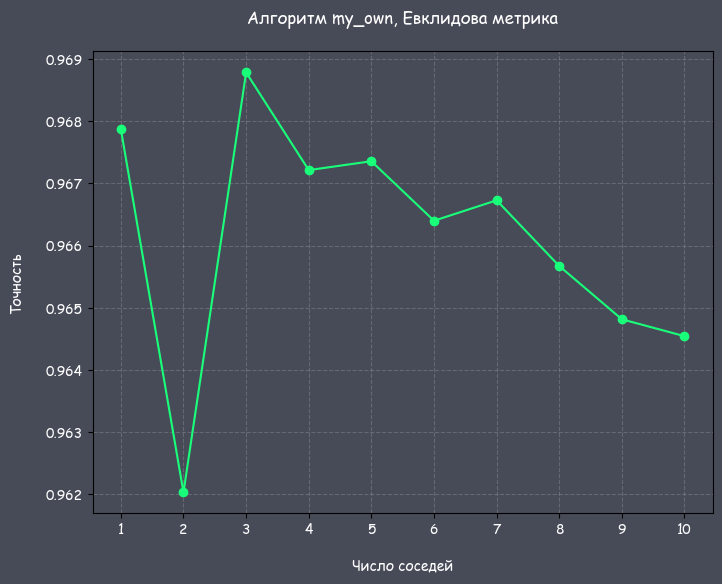

In [306]:
lists = sorted(acc_euc_my_own.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Алгоритм my_own, Евклидова метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

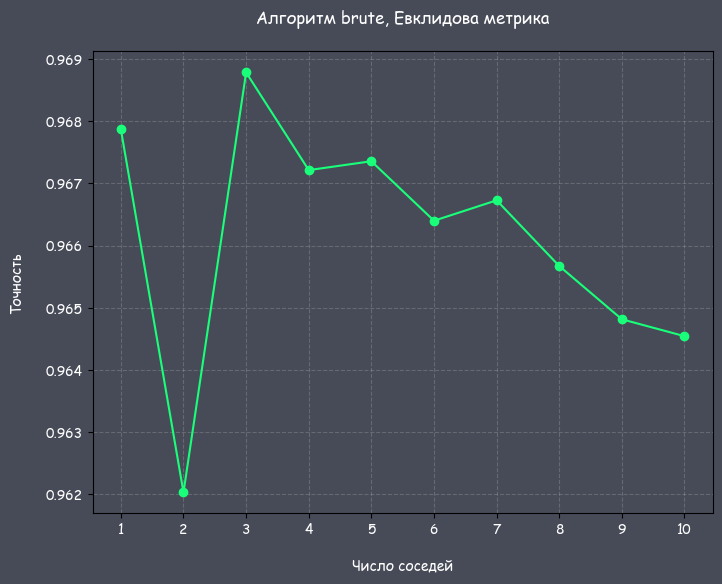

In [283]:
lists = sorted(acc_euc_brute.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Алгоритм brute, Евклидова метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

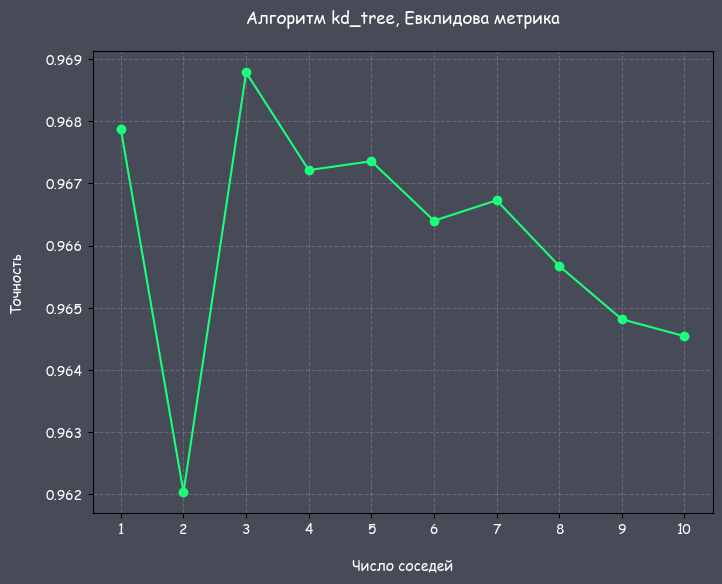

In [284]:
lists = sorted(acc_euc_kd_tree.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Алгоритм kd_tree, Евклидова метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

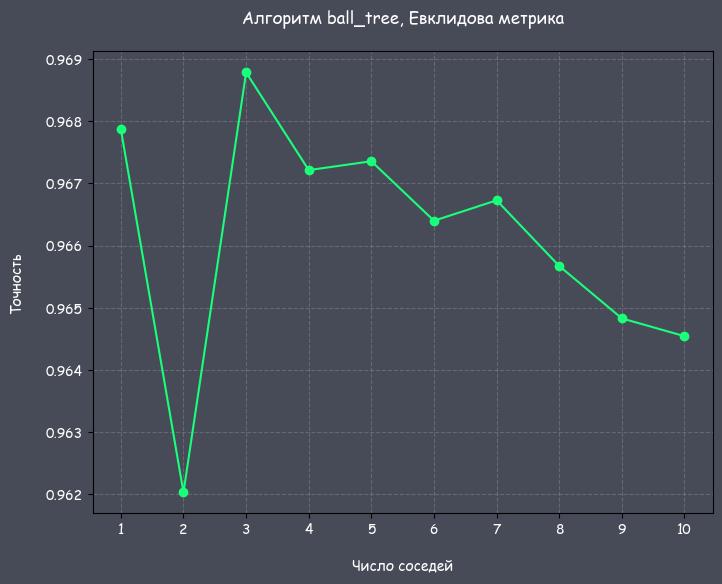

In [291]:
lists = sorted(acc_euc_ball_tree.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Алгоритм ball_tree, Евклидова метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

Максимальная точность:  0.9730999806015425


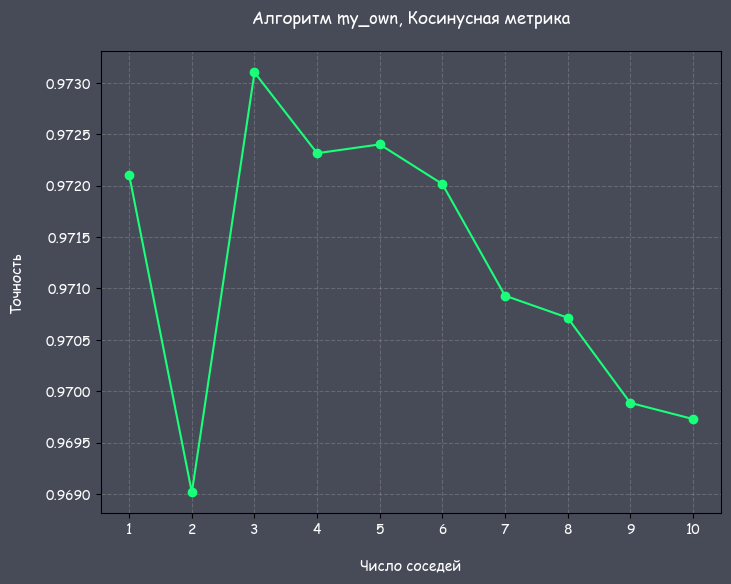

In [323]:
lists = sorted(acc_cos_my_own.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

print('Максимальная точность: ', max(b))

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Алгоритм my_own, Косинусная метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

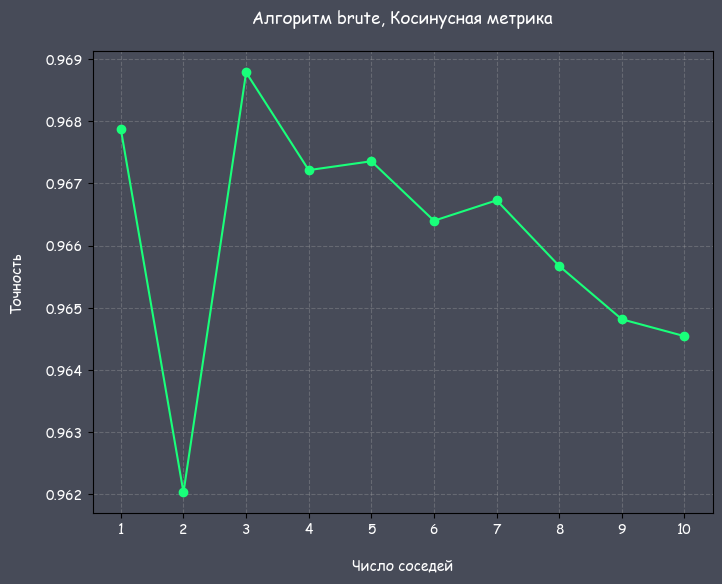

In [312]:
lists = sorted(acc_cos_brute.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Алгоритм brute, Косинусная метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

Лучше всего себя показывает метрика **cosine** при алгоритме **my_own**. Она лучше как по точности, так и по времени работы.

Графики точности не различаются, за исключением графика для алгоритма *my_own* и метрики *cosine*

На графиках при $k = 2$ наблюдается резкий спад в точности. Это связано с тем, что меткой для объекта, у которого два ближайших соседа имеют разные классы, может быть как метка первого, так и метка второго соседа. Это невзвешенный метод, поэтому каждая метка имеет равный "вес" и голосование проводится равновероятно по этим меткам

Также видно, что при $k = 3$ имеем самую высокую точность алгоритмов. 

С увеличением $k$ точность постепенно падает. Это также связано с равновероятным голосованиям по меткам ближайших соседей

## Эксперимент третий - *сравнение со взешенным методом KNN*

Рассматриваем все алгоритмы **взвешенного** поиска ближайших соседей и оцениваем точность и время работы алгоритмов для $k$ соседей, где $k \in [1, 10]$

Евклидова метрика используется для каждого метода поиска, в то время как косинусная только с методами *my_own* и *brute*

Используем 3-х фолдовую нестратифицированную кросс-валидацию

### Евклидова метрика

#### Метод *my_own*

In [151]:
my_own_dict = {'strategy': 'my_own', 'metric': 'euclidean', 'weights': True, 'test_block_size': 100}

In [152]:
%%time
w_acc_euc_my_own = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **my_own_dict)

Wall time: 1min 38s


#### Метод *brute*

In [153]:
brute_dict = {'strategy': 'brute', 'metric': 'euclidean', 'weights': True, 'test_block_size': 100}

In [154]:
%%time
w_acc_euc_brute = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **brute_dict)

Wall time: 2min 34s


#### Метод *kd_tree*

In [155]:
kd_tree_dict = {'strategy': 'kd_tree', 'metric': 'euclidean', 'weights': True, 'test_block_size': 100}

In [156]:
%%time
w_acc_euc_kd_tree = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **kd_tree_dict)

Wall time: 50min 19s


#### Метод *ball_tree*

In [157]:
ball_tree_dict = {'strategy': 'ball_tree', 'metric': 'euclidean', 'weights': True, 'test_block_size': 100}

In [158]:
%%time
w_acc_euc_ball_tree = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **ball_tree_dict)

Wall time: 39min 58s


### Косинусная метрика

#### Метод *my_own*

In [159]:
my_own_dict = {'strategy': 'my_own', 'metric': 'cosine', 'weights': True, 'test_block_size': 100}

In [160]:
%%time
w_acc_cos_my_own = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **my_own_dict)

Wall time: 1min 37s


#### Метод *brute*

In [161]:
brute_dict = {'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 100}

In [162]:
%%time
w_acc_cos_brute = knn_cross_val_score(X_np, y_np, range(1, 11), 'accuracy', None, **brute_dict)

Wall time: 2min 34s


### Оценка результатов эксперимента

Для каждой метрики быстрее всего отработал алгоритм **my_own** с показателями времени, равными **1**$min$**38**$s$ при евклидовой и **1**$min$**37**$s$ при косинусной.

Методы *kd_tree* и *ball_tree* показали достаточно большое время работы при кросс-валидации взвешенного метода, так как на каждом новом фолде приходилось очередной раз проводить построение структур данных, как и не во взвешенном методе.

Вычисления оказались незначительно быстрее при косинусной метрике  

**Ранжирование по времени** 

*Евклидова метрика*: **my_own** ($1 min, 38 s$) $\longrightarrow$ **brute** ($2 min, 34 s$) $\longrightarrow$ **ball_tree** ($39 min, 58s$) $\longrightarrow$ **kd_tree** ($50 min, 19s$)

*Косинусная метрика*: **my_own** ($1 min, 37 s$) $\longrightarrow$ **brute** ($2 min, 34 s$)

По времени работы отличий от невзвешенного метода практически **не наблюдается**

#### Построение графиков зависимости точности от количества взвешенных ближайших соседей

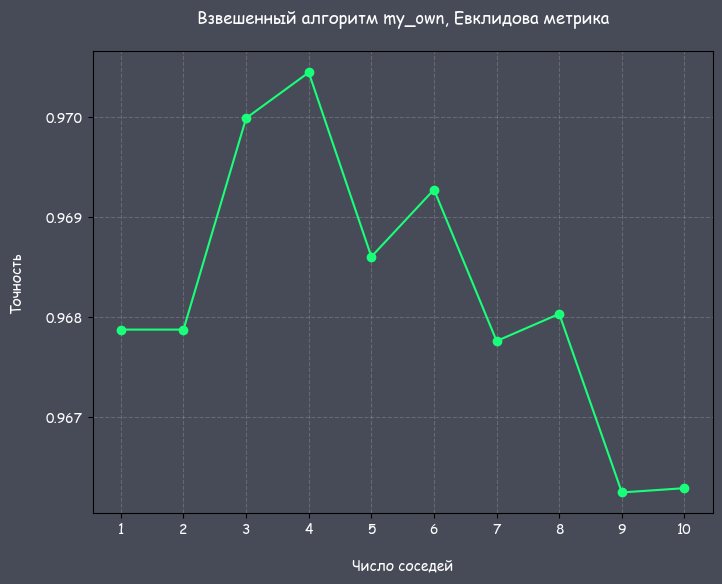

In [313]:
lists = sorted(w_acc_euc_my_own.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Взвешенный алгоритм my_own, Евклидова метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

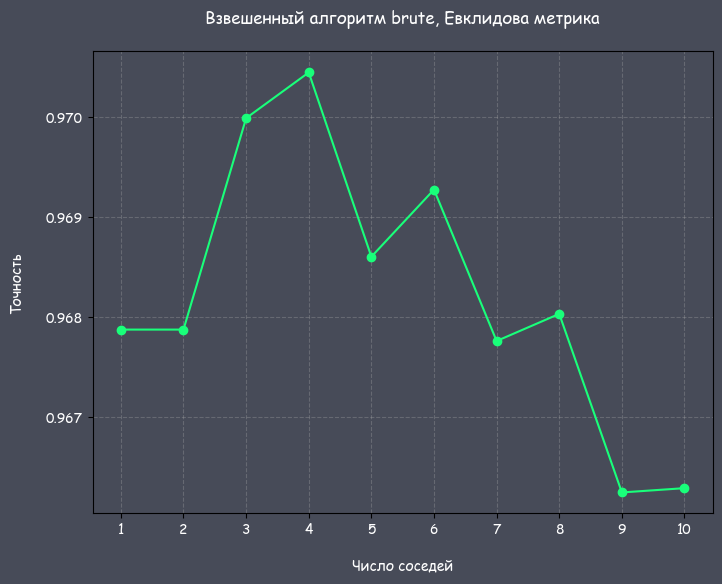

In [314]:
lists = sorted(w_acc_euc_brute.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Взвешенный алгоритм brute, Евклидова метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

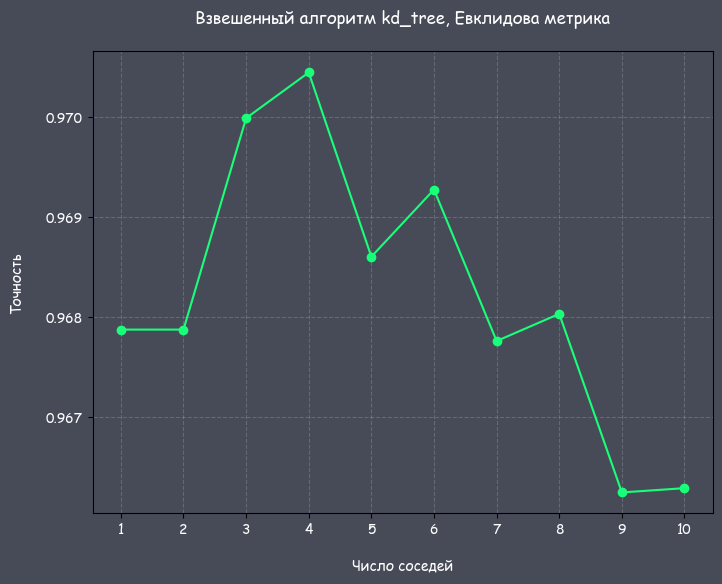

In [315]:
lists = sorted(w_acc_euc_kd_tree.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Взвешенный алгоритм kd_tree, Евклидова метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

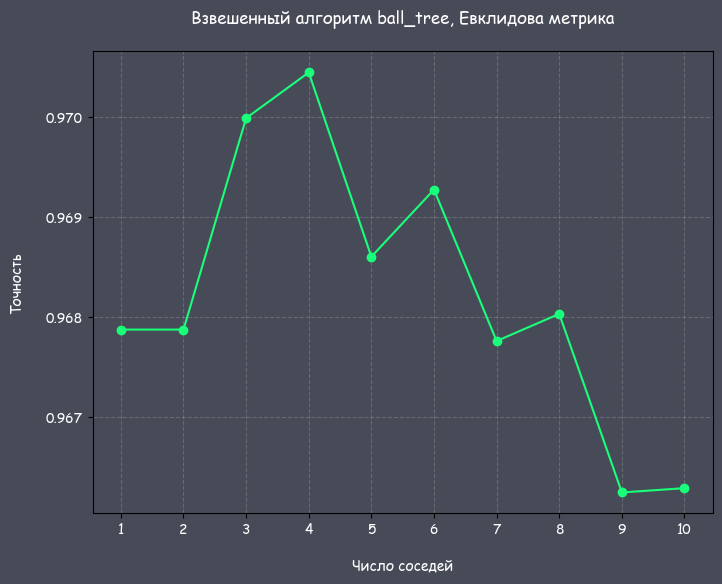

In [316]:
lists = sorted(w_acc_euc_ball_tree.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Взвешенный алгоритм ball_tree, Евклидова метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

Максимальная точность:  0.9740999801937931


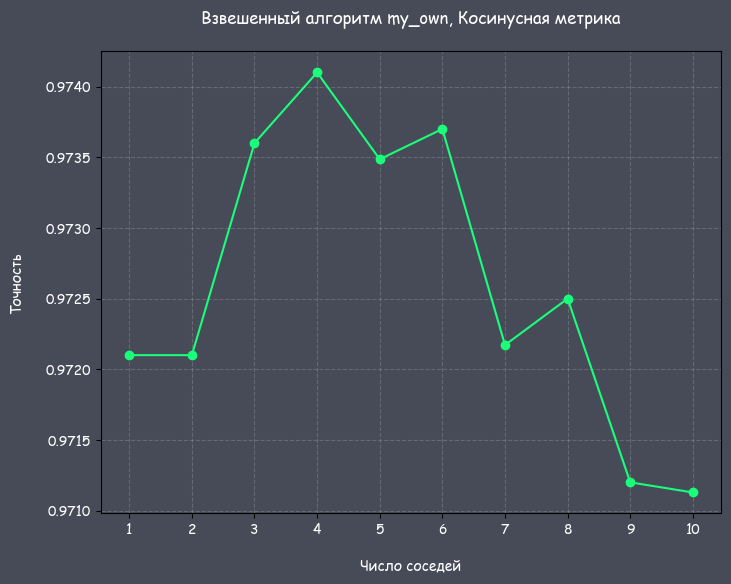

In [322]:
lists = sorted(w_acc_cos_my_own.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

print('Максимальная точность: ', max(b))

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Взвешенный алгоритм my_own, Косинусная метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

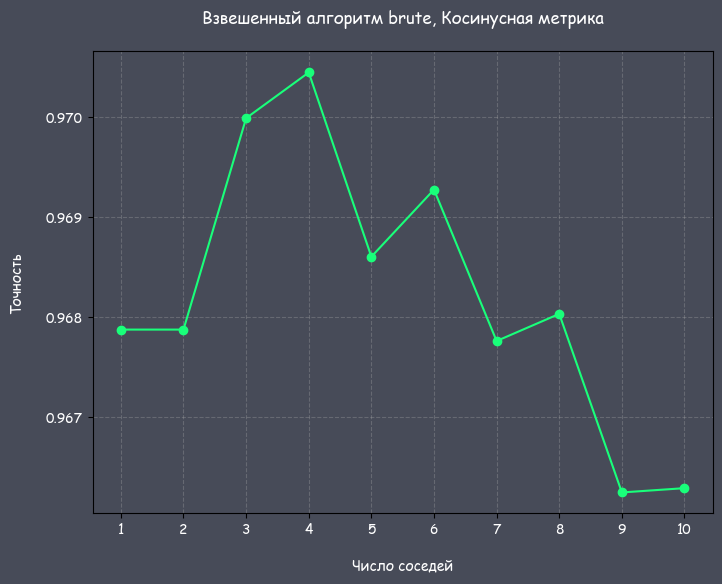

In [320]:
lists = sorted(w_acc_cos_brute.items()) # sorted by key
a, b = zip(*lists)
b = np.mean(np.array(b), axis=1)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#474b58')
ax.plot(a, b, '-o', color='#19ff7a')
ax.set_xlabel('Число соседей', color='white')
ax.set_ylabel('Точность', color='white')
ax.set_facecolor("#474b58")
ax.xaxis.labelpad=15.0
ax.yaxis.labelpad=15.0

plt.title('Взвешенный алгоритм brute, Косинусная метрика', color='white', pad=20)
plt.xticks(a, color='white')
plt.yticks(color='white')
plt.grid(alpha=0.3, linestyle = '--')
plt.rcParams["font.family"] = "cursive"
plt.show()

Лучше всего себя снова показывает метрика **cosine** при алгоритме **my_own**. Она лучше как по точности, так и по времени работы.

Графики точности не различаются, за исключением графика для алгоритма *my_own* и метрики *cosine*

На графиках (всех, кроме my_own cosine) при $k > 5$ наблюдается постепенный спад в точности. Вероятно, причиной служит то, что в большей окрестности объекта может находится множество различных классов, из которых выбор подходящего будет не совсем точным в предположении гипотезы компактности метрического алгоритма

Также видно, что при $k = 4$ имеем самую высокую точность алгоритмов. 

Сравнивая с невзвешенным методом, получаем, что взвешенный метод работает незначительно лучше. Точность лучшего алгоритма в невзвешенном методе - $0.973099$. Во взвешенном - $0.974099$

Получаем, что лучшая конфигурация для датасета MNIST - это **взвешенный** алгоритм поиска ближайших соседей **my_own** при использовании метрики **cosine** и числе ближайших соседей $k = 4$

## Эксперимент четвёртый - применяем лучший алгоритм

In [325]:
best_knn = KNNClassifier(4, 'my_own', 'cosine', True, 100)
best_knn.fit(X_train, y_train)

best_train_pred = best_knn.predict(X_train)
best_test_pred = best_knn.predict(X_test)

In [326]:
best_train_acc = get_accuracy(best_train_pred, y_train)
best_test_acc = get_accuracy(best_test_pred, y_test)

print("Лучшая точность на обучающей выборке - ", best_train_acc)
print("Лучшая точность на тестовой выборке - ", best_test_acc)

Лучшая точность на обучающей выборке -  1.0
Лучшая точность на тестовой выборке -  0.9752


In [327]:
print("Количество различающихся объектов на тестовой выборке: ", np.count_nonzero(best_test_pred != y_test))

Количество различающихся объектов на тестовой выборке:  248


### Оценка результатов эксперимента

Точность на тестовой выборке получилась **выше**, чем при кросс-валидации: $0.9752 > 0.97409$

In [337]:
print("Процент ошибок лучшего алгоритма на датасете MNIST: %.2f" % ((1.0 - best_test_acc) * 100) + "%")

Процент ошибок лучшего алгоритма на датасете MNIST: 2.48%


Лучший результат на датасете MNIST на текущий момент (2023 год) был получен в 2020 году для модели **Branching/Merging CNN + Homogeneous Vector Capsules**. Процент ошибок на ней равен **0.13%**. Точность **0.9987**

Также стоит отметить, что модифицированный алгоритм KNN - **Large-Margin kNN** имеет процент ошибок **0.9%** на данном датасете и находится на $61$ месте в мировом рейтинге

[Мировой рейтинг на датасете MNIST](https://paperswithcode.com/sota/image-classification-on-mnist)

In [342]:
conf_matrix = sklearn.metrics.confusion_matrix(y_test, best_test_pred)
print('Матрица ошибок\n\n',conf_matrix)

Матрица ошибок

 [[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1129    3    1    0    0    2    0    0    0]
 [   8    0 1009    1    1    0    0    8    5    0]
 [   0    1    3  976    1   12    0    4    9    4]
 [   2    1    0    0  946    0    6    2    0   25]
 [   4    0    0    9    1  863    7    1    4    3]
 [   3    3    0    0    1    3  948    0    0    0]
 [   2   10    4    0    1    0    0  998    0   13]
 [   7    1    2    9    3    3    5    4  936    4]
 [   7    7    2    5    7    3    1    4    3  970]]


In [354]:
!pip install seaborn

     -------------------------------------- 293.3/293.3 kB 2.0 MB/s eta 0:00:00


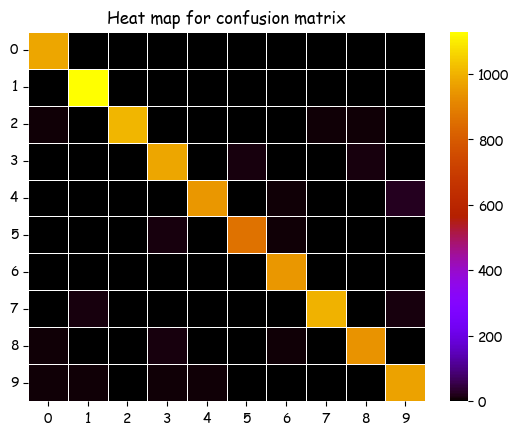

In [416]:
import seaborn as sns

fig, ax = plt.subplots()
ax = sns.heatmap(conf_matrix, cmap="gnuplot", linewidth=.5)
ax.set_title('Heat map for confusion matrix')
plt.yticks(rotation = 0)
plt.show()

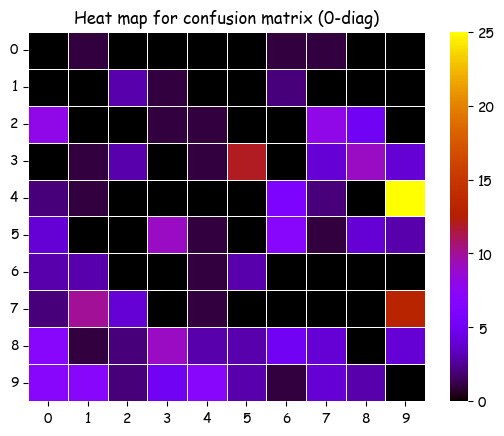

In [415]:
fig, ax = plt.subplots()

ax = sns.heatmap(conf_matrix * (np.ones_like(conf_matrix) - np.diag([1] * 10)) , cmap="gnuplot", linewidth=.5)
ax.set_title('Heat map for confusion matrix (0-diag)')
plt.yticks(rotation = 0)
plt.show()

Анализ матрицы ошибок показывает, что используемый метрический классификатор больше всего ошибается на паре цифр $(4, 9)$, путая 4 с 9. Также видна сильная связь для ошибок для следующих пар цифр (порядок важен): $3 \mapsto 5$, $7 \mapsto 9$, $7 \mapsto 1$, $5 \mapsto 3$, $8 \mapsto 3$

Заметна тенденция к увеличению числа ошибок для больших цифр, которые классификатор путает чаще, чем меньшие. 

Меньше всего ошибок допускается на цифрах: $0, 1, 6$. Для них число ошибок равно $3, 6, 10$ соответственно

Больше всего ошибок допускается на цифрах: $4, 8, 9$. Для них число ошибок равно $36, 38, 39$ соответственно

In [615]:
print("Сумма ошибок для каждой цифры:")
print(dict(zip(np.arange(0, 10), (conf_matrix * (np.ones_like(conf_matrix) - np.diag([1] * 10))).sum(axis=1))))

Сумма ошибок для каждой цифры:
{0: 3, 1: 6, 2: 23, 3: 34, 4: 36, 5: 29, 6: 10, 7: 30, 8: 38, 9: 39}


### Визуализация объектов, на которых были допущены ошибки

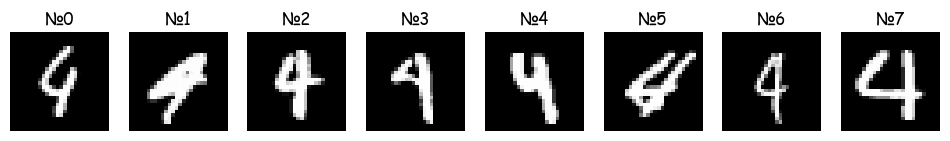

In [483]:
error_objects = X_test[(y_test == 4) & (best_test_pred == 9)][:8]
vizualize_mnist(error_objects)

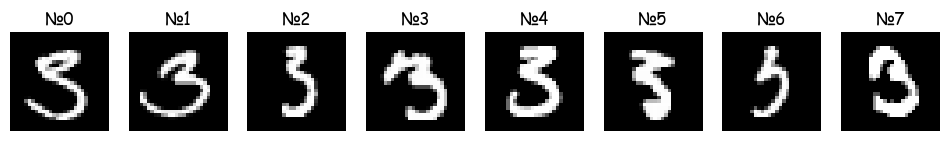

In [484]:
error_objects = X_test[(y_test == 3) & (best_test_pred == 5)][:8]
vizualize_mnist(error_objects)

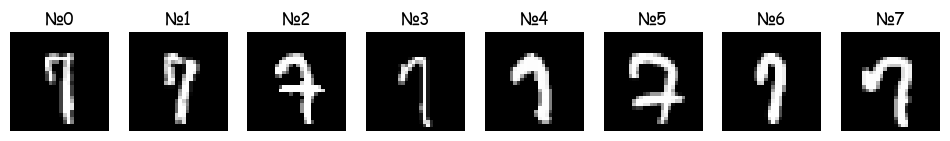

In [485]:
error_objects = X_test[(y_test == 7) & (best_test_pred == 9)][:8]
vizualize_mnist(error_objects)

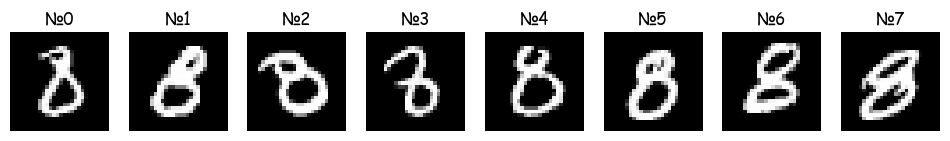

In [486]:
error_objects = X_test[(y_test == 8) & (best_test_pred == 3)][:8]
vizualize_mnist(error_objects)

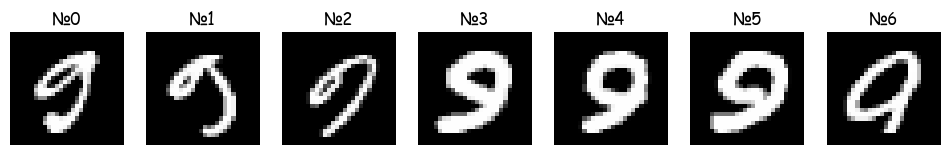

In [488]:
error_objects = X_test[(y_test == 9) & (best_test_pred == 0)][:8]
vizualize_mnist(error_objects)

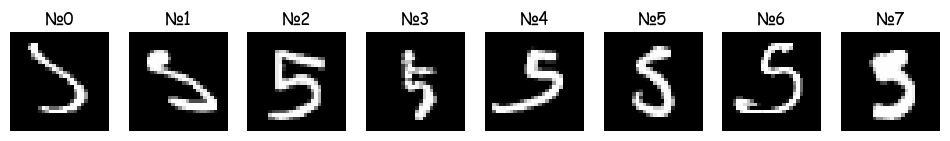

In [489]:
error_objects = X_test[(y_test == 5) & (best_test_pred == 3)][:8]
vizualize_mnist(error_objects)

Видно, что большинство объектов, на которых были допущены ошибки, действительно могут быть неоднозначными. Например, $7$ на 3 и 4 изображениях очень похожа на единицу.

Однако основная характерная черта "ошибочных" объектов в их визуальной дуальности. Также заметна разница в толщине линий и повороте цифры. Например, цифра $4$ на 1 изображении, либо $9$ на 3-5 изображениях имеют толстые линии. На втором изображении цифры $9$ девятка повёрнута очень неоднозначным образом.

Общие черты объектов, на которых были допущены ошибки иллюстрирует следующее изображение:

In [500]:
from IPython.core.display import Image, display
display(Image(url='https://a.d-cd.net/EEAAAgFqvOA-960.jpg', width=700))

## Эксперимент пятый - аугментация обучающей выборки

In [503]:
!pip install opencv-python

     ---------------------------------------- 38.1/38.1 MB 8.2 MB/s eta 0:00:00


### Подбор параметров величины поворота

In [540]:
import cv2

def image_rotate(image, angle): #  image 28 x 28
    rotation_matrix = cv2.getRotationMatrix2D((image.shape[0] // 2, image.shape[1] // 2), angle, 1.0)
    result = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    return result

In [541]:
X_train_best_rot = None
angles = np.array([-15, -10, -5, 5, 10, 15])
best_angle = None
best_accuracy = 0
params = {'strategy': 'my_own', 'metric': 'cosine', 'weights': True, 'test_block_size': 100}


for angle in angles:
    X_train_rot = np.array([image_rotate(obj.reshape(28, 28), angle).reshape(-1) for obj in X_train])
    res = knn_cross_val_score(X_train_rot, y_train, [4], "accuracy", None, **params)
    if res[4].mean() > best_accuracy:
        best_accuracy = res[4].mean()
        best_angle = angle
        X_train_best_rot = X_train_rot

In [542]:
print("Лучший угол поворота:", best_angle)
print("Лучшая средняя точность на аугментирующей выборке:", best_accuracy)

Лучший угол поворота: 5
Лучшая средняя точность на аугментирующей выборке: 0.9763000000000001


### Подбор параметров величины смещения 

In [562]:
def image_shift(image, x_shift, y_shift):
    shift_matrix = np.float32([[1, 0, x_shift],
                             [0, 1, y_shift]])
    result = cv2.warpAffine(image, shift_matrix, (image.shape[1], image.shape[0]))
    return result

In [563]:
X_train_best_shift = None
shifts = np.array([1, 2, 3])
best_shift = None
best_accuracy = 0
params = {'strategy': 'my_own', 'metric': 'cosine', 'weights': True, 'test_block_size': 100}


for x_shift in shifts:
    for y_shift in shifts:
        X_train_shift = np.array([image_shift(obj.reshape(28, 28), x_shift, y_shift).reshape(-1) for obj in X_train])
        res = knn_cross_val_score(X_train_shift, y_train, [4], "accuracy", None, **params)
        if res[4].mean() > best_accuracy:
            best_accuracy = res[4].mean()
            best_shift = (x_shift, y_shift)
            X_train_best_shift = X_train_shift

In [564]:
print("Лучшая величина смещения:", best_shift)
print("Лучшая средняя точность на аугментирующей выборке:", best_accuracy)

Лучшая величина смещения: (3, 1)
Лучшая средняя точность на аугментирующей выборке: 0.9742000000000001


### Подбор параметров дисперсии фильтра Гаусса

In [565]:
def image_gauss_filter(image, sigma_x, sigma_y, kernel=5):
    res = cv2.GaussianBlur(image, (kernel, kernel), sigmaX=sigma_x, sigmaY=sigma_y)
    return res

In [566]:
X_train_best_gauss = None
devs = np.array([0.5, 1, 1.5])
best_dev = None
best_accuracy = 0
params = {'strategy': 'my_own', 'metric': 'cosine', 'weights': True, 'test_block_size': 100}


for x_dev in devs:
    for y_dev in devs:
        X_train_gauss = np.array([image_gauss_filter(obj.reshape(28, 28), x_dev, y_dev).reshape(-1) for obj in X_train])
        res = knn_cross_val_score(X_train_gauss, y_train, [4], "accuracy", None, **params)
        if res[4].mean() > best_accuracy:
            best_accuracy = res[4].mean()
            best_dev = (x_dev, y_dev)
            X_train_best_gauss = X_train_gauss

In [567]:
print("Лучшая величина смещения:", best_dev)
print("Лучшая средняя точность на аугментирующей выборке:", best_accuracy)

Лучшая величина смещения: (1.0, 1.0)
Лучшая средняя точность на аугментирующей выборке: 0.9772500000000001


### Подбор морфологической операции

In [642]:
def image_morphopen(image):
    kernel = np.ones((2, 2), np.uint8)
    res = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return res


def image_morphclose(image):
    kernel = np.ones((2,2),np.uint8)
    res = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return res


def image_morpherode(image):
    kernel = np.ones((2, 2), np.uint8)
    res = cv2.erode(image, kernel, iterations=1)
    return res
    

def image_morphdilate(image):
    kernel = np.ones((2, 2), np.uint8)
    res = cv2.dilate(image, kernel, iterations=1)
    return res

In [577]:
X_train_best_morph = None
morphs = [image_morphopen, image_morphclose, image_morpherode, image_morphdilate]
morphs_str = ['image_morphopen', 'image_morphclose', 'image_morpherode', 'image_morphdilate']
best_morph = None
best_accuracy = 0
params = {'strategy': 'my_own', 'metric': 'cosine', 'weights': True, 'test_block_size': 100}


for n, morph in enumerate(morphs):
    X_train_morph = np.array([morph(obj.reshape(28, 28)).reshape(-1) for obj in X_train])
    res = knn_cross_val_score(X_train_morph, y_train, [4], "accuracy", None, **params)
    if res[4].mean() > best_accuracy:
        best_accuracy = res[4].mean()
        best_morph = morphs_str[n]
        X_train_best_morph = X_train_morph

In [578]:
print("Лучшая морфологическая операция:", best_morph)
print("Лучшая средняя точность на аугментирующей выборке:", best_accuracy)

Лучшая морфологическая операция: image_morphclose
Лучшая средняя точность на аугментирующей выборке: 0.9729166666666668


In [584]:
X_train_aug = X_train.copy()

(60000, 784)

In [585]:
X_train_aug = np.concatenate((X_train_aug, X_train_best_rot), axis=0)
X_train_aug.shape

(120000, 784)

In [586]:
X_train_aug = np.concatenate((X_train_aug, X_train_best_shift), axis=0)
X_train_aug.shape

(180000, 784)

In [587]:
X_train_aug = np.concatenate((X_train_aug, X_train_best_gauss), axis=0)
X_train_aug.shape

(240000, 784)

In [588]:
X_train_aug = np.concatenate((X_train_aug, X_train_best_morph), axis=0)
X_train_aug.shape

(300000, 784)

In [589]:
del X_train_best_rot
del X_train_best_shift
del X_train_best_gauss
del X_train_best_morph

In [591]:
X_train_best_all = X_train.copy()
X_train_best_all = np.array([image_rotate(obj.reshape(28, 28), 5).reshape(-1) for obj in X_train_best_all])
X_train_best_all = np.array([image_shift(obj.reshape(28, 28), 3, 1).reshape(-1) for obj in X_train_best_all])
X_train_best_all = np.array([image_gauss_filter(obj.reshape(28, 28), 1.0, 1.0).reshape(-1) for obj in X_train_best_all])
X_train_best_all = np.array([image_morphclose(obj.reshape(28, 28)).reshape(-1) for obj in X_train_best_all])
X_train_best_all.shape

(60000, 784)

In [592]:
X_train_aug = np.concatenate((X_train_aug, X_train_best_all), axis=0)
X_train_aug.shape

(360000, 784)

In [593]:
del X_train_best_all

In [594]:
y_train_aug = y_train.copy()
y_train_aug = np.concatenate((y_train_aug, y_train_aug), axis=0)

In [599]:
y_train_aug.shape

(120000,)

In [600]:
y_train_aug = np.concatenate((y_train_aug, y_train), axis=0)
y_train_aug = np.concatenate((y_train_aug, y_train), axis=0)
y_train_aug = np.concatenate((y_train_aug, y_train), axis=0)

In [601]:
y_train_aug.shape

(300000,)

In [602]:
y_train_aug = np.concatenate((y_train_aug, y_train), axis=0)
y_train_aug.shape

(360000,)

In [603]:
best_knn = KNNClassifier(4, 'my_own', 'cosine', True, 100)
best_knn.fit(X_train_aug, y_train_aug)

best_test_pred = best_knn.predict(X_test)

In [604]:
best_test_acc = get_accuracy(best_test_pred, y_test)
print("Лучшая точность на тестовой выборке - ", best_test_acc)
print("Количество различающихся объектов на тестовой выборке: ", np.count_nonzero(best_test_pred != y_test))

Лучшая точность на тестовой выборке -  0.9822
Количество различающихся объектов на тестовой выборке:  178


### Оценка результатов эксперимента

In [606]:
print("Процент ошибок лучшего алгоритма на аугментированном датасете MNIST: %.2f" % ((1.0 - best_test_acc) * 100) + "%")

Процент ошибок лучшего алгоритма на аугментированном датасете MNIST: 1.78%


Точность повысилась значительно, в сравнении с неаугментированными данными. Разница в точности составляет $0.9822 - 0.9752 = 0.007$, разница в процентном соотношении ошибок составляет $2.48$% $-$ $1.78$% = $0.7$%

In [608]:
conf_matrix_aug = sklearn.metrics.confusion_matrix(y_test, best_test_pred)
print('Матрица ошибок\n\n',conf_matrix_aug)

Матрица ошибок

 [[ 977    0    0    0    0    0    0    2    1    0]
 [   0 1131    3    0    0    0    1    0    0    0]
 [   6    1 1011    0    1    0    2    9    2    0]
 [   0    0    1  990    1    7    0    4    5    2]
 [   0    0    0    0  959    0    3    3    2   15]
 [   3    1    0    8    1  871    3    1    1    3]
 [   4    3    0    0    2    3  946    0    0    0]
 [   0    8    4    1    1    0    0 1007    0    7]
 [   2    0    2    6    3    3    3    4  948    3]
 [   2    4    0    4    5    2    1    6    3  982]]


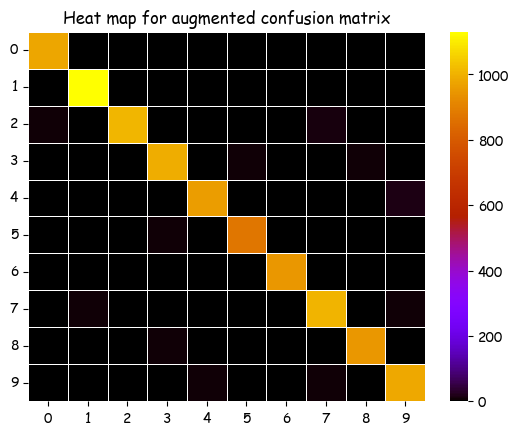

In [611]:
fig, ax = plt.subplots()
ax = sns.heatmap(conf_matrix_aug, cmap="gnuplot", linewidth=.5)
ax.set_title('Heat map for augmented confusion matrix')
plt.yticks(rotation = 0)
plt.show()

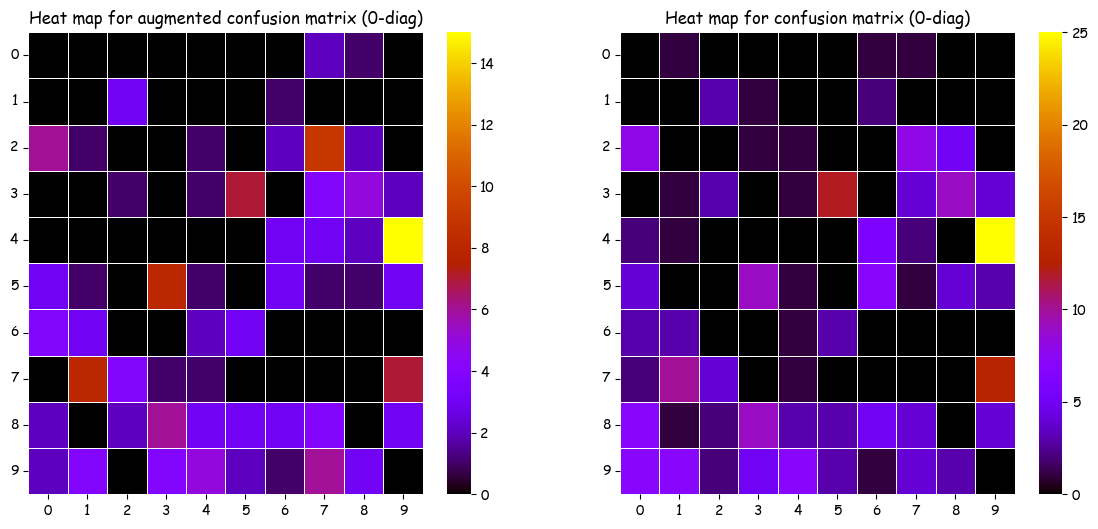

In [641]:
plt.rcParams["figure.figsize"] = (14,6)
ax1 = plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_aug * (np.ones_like(conf_matrix_aug) - np.diag([1] * 10)) , cmap="gnuplot", linewidth=.5)
ax1.set_title('Heat map for augmented confusion matrix (0-diag)')
plt.yticks(rotation = 0)
ax2 = plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix * (np.ones_like(conf_matrix) - np.diag([1] * 10)) , cmap="gnuplot", linewidth=.5)
ax2.set_title('Heat map for confusion matrix (0-diag)')
plt.yticks(rotation = 0)
plt.show()

Видим, что были исправлены ошибки, например, связанные с определением $4$ как $0$, либо как $1$

Поворот позволил избавиться от ошибок, при которых несимметричные цифры предсказываются неправильно. Например, $4 \rightarrow 1$, либо $2 \rightarrow 3$

Сдвиг позволил избавиться от ошибок, связанных с неотцентрированными цифрами

Фильтрация Гаусса помогла лучше определять цифры, на которых есть шум

Закрытие помогло лучше определять цифры с внутренними "отверстиями" (например, цифра $8$)

In [616]:
print("Сумма ошибок для каждой цифры:")
print(dict(zip(np.arange(0, 10), (conf_matrix_aug * (np.ones_like(conf_matrix_aug) - np.diag([1] * 10))).sum(axis=1))))

Сумма ошибок для каждой цифры:
{0: 3, 1: 4, 2: 21, 3: 20, 4: 23, 5: 21, 6: 12, 7: 21, 8: 26, 9: 27}


### Визуализация объектов, на которых были допущены ошибки

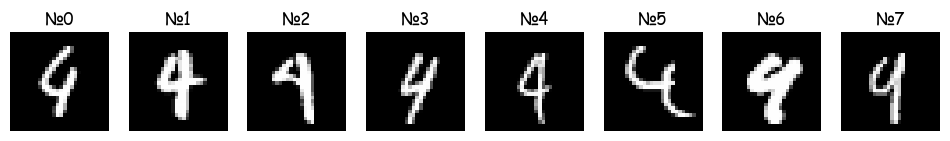

In [617]:
error_objects = X_test[(y_test == 4) & (best_test_pred == 9)][:8]
vizualize_mnist(error_objects)

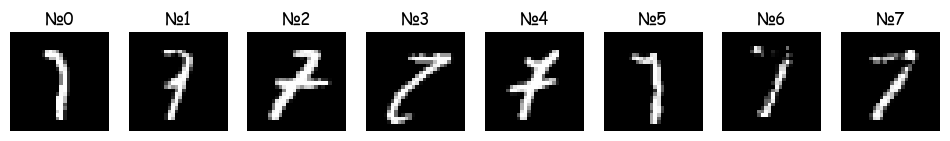

In [618]:
error_objects = X_test[(y_test == 7) & (best_test_pred == 1)][:8]
vizualize_mnist(error_objects)

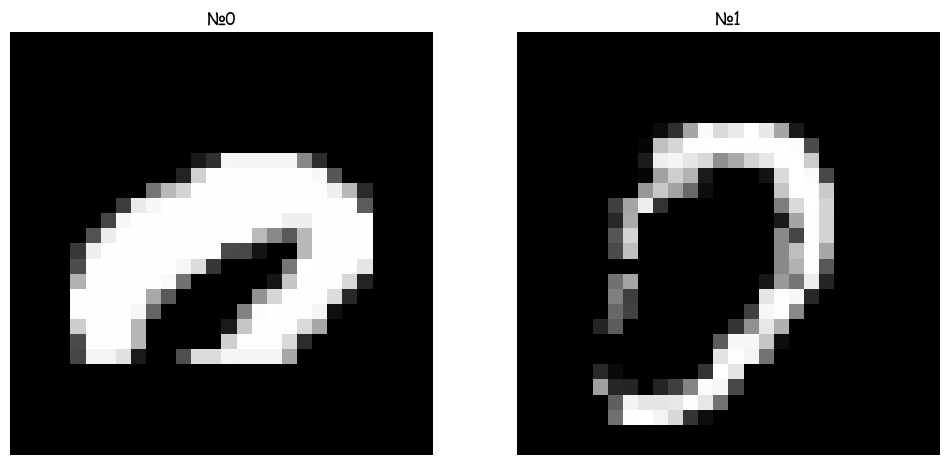

In [620]:
error_objects = X_test[(y_test == 0) & (best_test_pred == 7)][:2]
vizualize_mnist(error_objects)

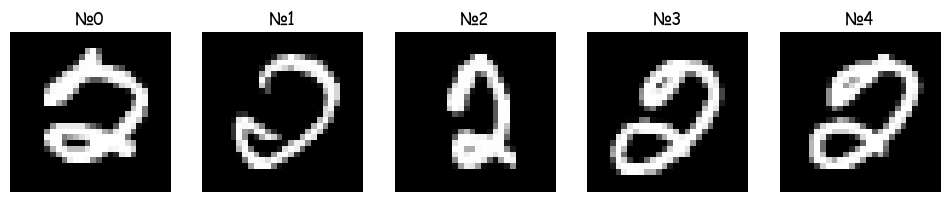

In [622]:
error_objects = X_test[(y_test == 2) & (best_test_pred == 0)][:5]
vizualize_mnist(error_objects)

## Эксперимент шестой - аугментация тестовой выборки

### Подбор параметров величины поворота

In [643]:
X_test_best_rot = None
angles = np.array([-15, -10, -5, 5, 10, 15])
best_angle = None
best_accuracy = 0
params = {'strategy': 'my_own', 'metric': 'cosine', 'weights': True, 'test_block_size': 100}

for angle in angles:
    X_test_rot = np.array([image_rotate(obj.reshape(28, 28), angle).reshape(-1) for obj in X_test])
    res = knn_cross_val_score(X_test_rot, y_test, [4], "accuracy", None, **params)
    if res[4].mean() > best_accuracy:
        best_accuracy = res[4].mean()
        best_angle = angle
        X_test_best_rot = X_test_rot

In [644]:
print("Лучший угол поворота:", best_angle)
print("Лучшая средняя точность на аугментирующей выборке:", best_accuracy)

Лучший угол поворота: -5
Лучшая средняя точность на аугментирующей выборке: 0.9561016389581369


### Подбор параметров величины смещения

In [645]:
X_test_best_shift = None
shifts = np.array([1, 2, 3])
best_shift = None
best_accuracy = 0
params = {'strategy': 'my_own', 'metric': 'cosine', 'weights': True, 'test_block_size': 100}

for x_shift in shifts:
    for y_shift in shifts:
        X_test_shift = np.array([image_shift(obj.reshape(28, 28), x_shift, y_shift).reshape(-1) for obj in X_test])
        res = knn_cross_val_score(X_test_shift, y_test, [4], "accuracy", None, **params)
        if res[4].mean() > best_accuracy:
            best_accuracy = res[4].mean()
            best_shift = (x_shift, y_shift)
            X_test_best_shift = X_test_shift

In [646]:
print("Лучшая величина смещения:", best_shift)
print("Лучшая средняя точность на аугментирующей выборке:", best_accuracy)

Лучшая величина смещения: (1, 3)
Лучшая средняя точность на аугментирующей выборке: 0.9515018088491513


### Подбор параметров дисперсии фильтра Гаусса

In [647]:
X_test_best_gauss = None
devs = np.array([0.5, 1, 1.5])
best_dev = None
best_accuracy = 0
params = {'strategy': 'my_own', 'metric': 'cosine', 'weights': True, 'test_block_size': 100}

for x_dev in devs:
    for y_dev in devs:
        X_test_gauss = np.array([image_gauss_filter(obj.reshape(28, 28), x_dev, y_dev).reshape(-1) for obj in X_test])
        res = knn_cross_val_score(X_test_gauss, y_test, [4], "accuracy", None, **params)
        if res[4].mean() > best_accuracy:
            best_accuracy = res[4].mean()
            best_dev = (x_dev, y_dev)
            X_test_best_gauss = X_test_gauss

In [648]:
print("Лучшая величина смещения:", best_dev)
print("Лучшая средняя точность на аугментирующей выборке:", best_accuracy)

Лучшая величина смещения: (1.5, 1.0)
Лучшая средняя точность на аугментирующей выборке: 0.9584017189961348


### Подбор морфологической операции

In [649]:
X_test_best_morph = None
morphs = [image_morphopen, image_morphclose, image_morpherode, image_morphdilate]
morphs_str = ['image_morphopen', 'image_morphclose', 'image_morpherode', 'image_morphdilate']
best_morph = None
best_accuracy = 0
params = {'strategy': 'my_own', 'metric': 'cosine', 'weights': True, 'test_block_size': 100}


for n, morph in enumerate(morphs):
    X_test_morph = np.array([morph(obj.reshape(28, 28)).reshape(-1) for obj in X_test])
    res = knn_cross_val_score(X_test_morph, y_test, [4], "accuracy", None, **params)
    if res[4].mean() > best_accuracy:
        best_accuracy = res[4].mean()
        best_morph = morphs_str[n]
        X_test_best_morph = X_test_morph

In [650]:
print("Лучшая морфологическая операция:", best_morph)
print("Лучшая средняя точность на аугментирующей выборке:", best_accuracy)

Лучшая морфологическая операция: image_morphdilate
Лучшая средняя точность на аугментирующей выборке: 0.9502017088331508


In [651]:
X_test_aug = X_test.copy()
X_test_aug = np.concatenate((X_test_aug, X_test_best_rot), axis=0)
X_test_aug = np.concatenate((X_test_aug, X_test_best_shift), axis=0)
X_test_aug = np.concatenate((X_test_aug, X_test_best_gauss), axis=0)
X_test_aug = np.concatenate((X_test_aug, X_test_best_morph), axis=0)
X_test_aug.shape

(50000, 784)

In [652]:
del X_test_best_rot
del X_test_best_shift
del X_test_best_gauss
del X_test_best_morph

In [658]:
X_test_best_all = X_test.copy()

In [659]:
X_test_best_all = np.array([image_rotate(obj.reshape(28, 28), best_angle).reshape(-1) for obj in X_test_best_all])
X_test_best_all.shape

(10000, 784)

In [660]:
X_test_best_all = np.array([image_shift(obj.reshape(28, 28), best_shift[0], best_shift[1]).reshape(-1) for obj in X_test_best_all])

In [661]:
X_test_best_all = np.array([image_gauss_filter(obj.reshape(28, 28), best_dev[0], best_dev[1]).reshape(-1) for obj in X_test_best_all])

In [663]:
X_test_best_all = np.array([image_morphdilate(obj.reshape(28, 28)).reshape(-1) for obj in X_test_best_all])

In [664]:
X_test_aug = np.concatenate((X_test_aug, X_test_best_all), axis=0)
X_test_aug.shape

(60000, 784)

In [665]:
del X_test_best_all

In [666]:
y_test_aug = y_test.copy()
y_test_aug = np.concatenate((y_test_aug, y_test), axis=0)
y_test_aug = np.concatenate((y_test_aug, y_test), axis=0)
y_test_aug = np.concatenate((y_test_aug, y_test), axis=0)
y_test_aug = np.concatenate((y_test_aug, y_test), axis=0)
y_test_aug = np.concatenate((y_test_aug, y_test), axis=0)
y_test_aug.shape

(60000,)

In [680]:
best_knn = KNNClassifier(4, 'my_own', 'cosine', True, 100)
best_knn.fit(X_np, y_np)
best_test_pred = best_knn.predict(X_test_aug)
best_test_acc = get_accuracy(best_test_pred, y_test_aug)

In [681]:
print("Лучшая точность на аугментированной тестовой выборке - ", best_test_acc)
print("Количество различающихся объектов на аугментированной тестовой выборке: ", np.count_nonzero(best_test_pred != y_test_aug))

Лучшая точность на аугментированной тестовой выборке -  0.7774
Количество различающихся объектов на аугментированной тестовой выборке:  13356


### Оценка результатов эксперимента

In [682]:
print("Процент ошибок лучшего алгоритма на аугментированном датасете MNIST: %.2f" % ((1.0 - best_test_acc) * 100) + "%")

Процент ошибок лучшего алгоритма на аугментированном датасете MNIST: 22.26%


Видим, что точность сильно ухучшилась. Данный подход (в отличие от 5 эксперимента) позволяет взглянуть на то, как модель будет работать на реальных данных, в которых могут быть сильно искажённые цифры.

In [683]:
conf_matrix_aug_test = sklearn.metrics.confusion_matrix(y_test_aug, best_test_pred)
print('Матрица ошибок\n\n', conf_matrix_aug_test)

Матрица ошибок

 [[4988   99   11  121    2   42   15    8  571   23]
 [   0 4827    5    7    2    1    0 1951    5   12]
 [ 533   11 4454  154    5   10    9  824  152   40]
 [  12    6   61 4768   14   19    4  421  275  480]
 [ 345   19   65   20 4599    1  438   27  184  194]
 [  13   11   12  308   25 4024   32   39  672  216]
 [ 232  162  178  153    4   21 4299    9  690    0]
 [  20   22   15   41  156    9   41 5414   35  415]
 [  95   21    8   13   46   47   31  344 4694  545]
 [ 509   18    7   15  225   13  440  151   99 4577]]


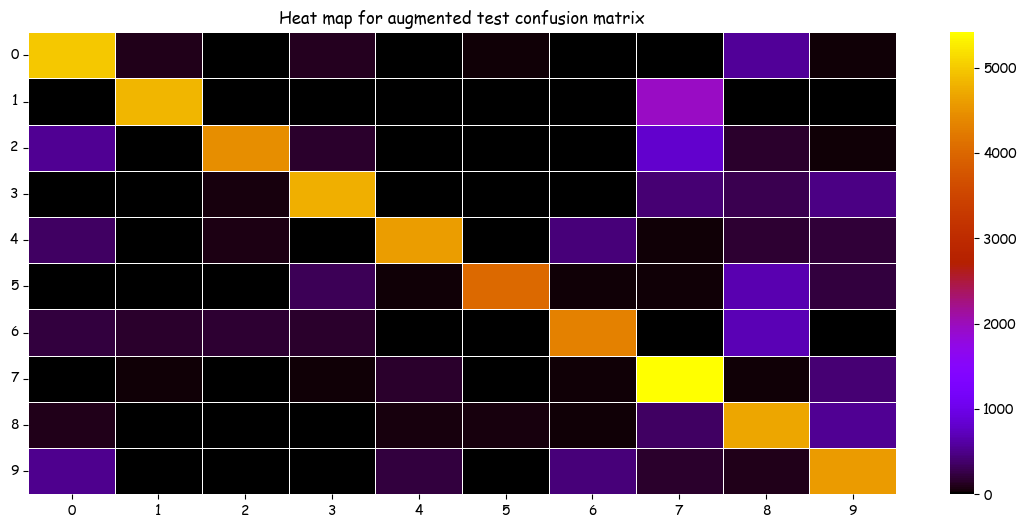

In [684]:
fig, ax = plt.subplots()
ax = sns.heatmap(conf_matrix_aug_test, cmap="gnuplot", linewidth=.5)
ax.set_title('Heat map for augmented test confusion matrix')
plt.yticks(rotation = 0)
plt.show()

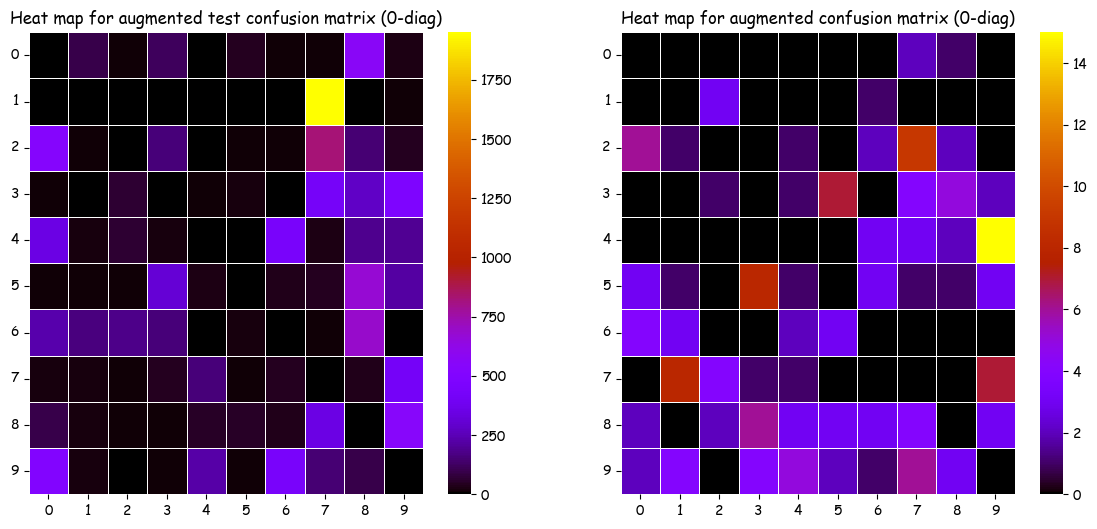

In [685]:
plt.rcParams["figure.figsize"] = (14,6)
ax1 = plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_aug_test * (np.ones_like(conf_matrix_aug_test) - np.diag([1] * 10)) , cmap="gnuplot", linewidth=.5)
ax1.set_title('Heat map for augmented test confusion matrix (0-diag)')
plt.yticks(rotation = 0)
ax2 = plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_aug * (np.ones_like(conf_matrix_aug) - np.diag([1] * 10)) , cmap="gnuplot", linewidth=.5)
ax2.set_title('Heat map for augmented confusion matrix (0-diag)')
plt.yticks(rotation = 0)
plt.show()

При таком подходе видно, что на "реальных" данных больше всего ошибок именно на парах цифр $1 \rightarrow 7$ и $2 \rightarrow 7$

Фактически, отличие данного подхода от похода в 5-м эксперименте заключается в том, что мы обучаемся на сырых данных без каких-либо аугментаций, используя в качестве тестовой выборки данные, приближённые к реальным.

In [686]:
print("Сумма ошибок для каждой цифры:")
print(dict(zip(np.arange(0, 10), (conf_matrix_aug_test * (np.ones_like(conf_matrix_aug_test) - np.diag([1] * 10))).sum(axis=1))))

Сумма ошибок для каждой цифры:
{0: 892, 1: 1983, 2: 1738, 3: 1292, 4: 1293, 5: 1328, 6: 1449, 7: 754, 8: 1150, 9: 1477}


### Визуализация объектов, на которых были допущены ошибки

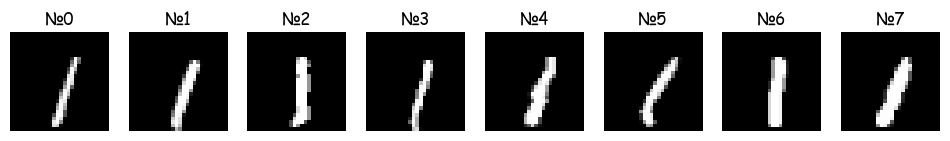

In [687]:
error_objects = X_test_aug[(y_test_aug == 1) & (best_test_pred == 7)][:8]
vizualize_mnist(error_objects)

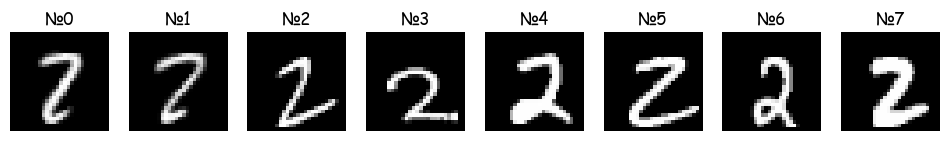

In [688]:
error_objects = X_test_aug[(y_test_aug == 2) & (best_test_pred == 7)][:8]
vizualize_mnist(error_objects)

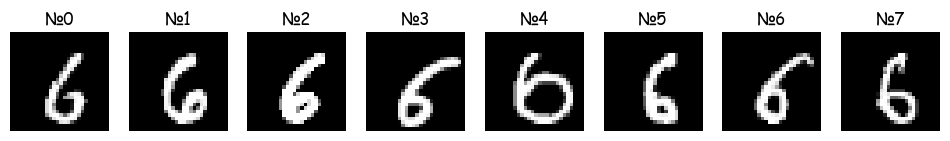

In [689]:
error_objects = X_test_aug[(y_test_aug == 6) & (best_test_pred == 8)][:8]
vizualize_mnist(error_objects)